<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cat-vs.-Dog-Image-Classification" data-toc-modified-id="Cat-vs.-Dog-Image-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cat vs. Dog Image Classification</a></span><ul class="toc-item"><li><span><a href="#Exercise-1:-Fine-tune" data-toc-modified-id="Exercise-1:-Fine-tune-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exercise 1: Fine-tune</a></span></li><li><span><a href="#Explore-the-Example-Data" data-toc-modified-id="Explore-the-Example-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Explore the Example Data</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data augmentation</a></span><ul class="toc-item"><li><span><a href="#Exploring-Data-Augmentation" data-toc-modified-id="Exploring-Data-Augmentation-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Exploring Data Augmentation</a></span></li><li><span><a href="#Add-Data-Augmentation-to-the-Preprocessing-Step" data-toc-modified-id="Add-Data-Augmentation-to-the-Preprocessing-Step-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Add Data Augmentation to the Preprocessing Step</a></span></li></ul></li><li><span><a href="#Using-pre-trained-Resnet" data-toc-modified-id="Using-pre-trained-Resnet-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Using pre-trained Resnet</a></span></li><li><span><a href="#Fine-tune" data-toc-modified-id="Fine-tune-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Fine-tune</a></span></li></ul></li></ul></div>

# Cat vs. Dog Image Classification

## Exercise 1: Fine-tune
Estimated completion time: 10 minutes

In Exercise 1, we built a convnet from scratch, and were able to achieve an accuracy of about 60%. With the addition of data augmentation and dropout in Exercise 2, we were able to increase accuracy to about 70%. That seems decent, but 20% is still too high of an error rate. Maybe we just don't have enough training data available to properly solve the problem. What other approaches can we try?

In this exercise, we'll look at two techniques for repurposing feature data generated from image models that have already been trained on large sets of data, and fine tuning, and use them to improve the accuracy of our cat vs. dog classification model.

We will follow these steps:

1. Explore how data augmentation works by making random transformations to training images.
2. Add data augmentation to our data preprocessing.
3. Use pretrained Resnet
4. Fine tune the model and evaluate loss and accuracy.

Let's get started!

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

## Explore the Example Data

In [2]:
import os 
base_dir = './data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [3]:
rain_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])

['cat.127.jpg', 'cat.126.jpg', 'cat.125.jpg', 'cat.124.jpg', 'cat.123.jpg', 'cat.122.jpg', 'cat.121.jpg', 'cat.120.jpg', 'cat.119.jpg', 'cat.118.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the train and validation directories:

In [4]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

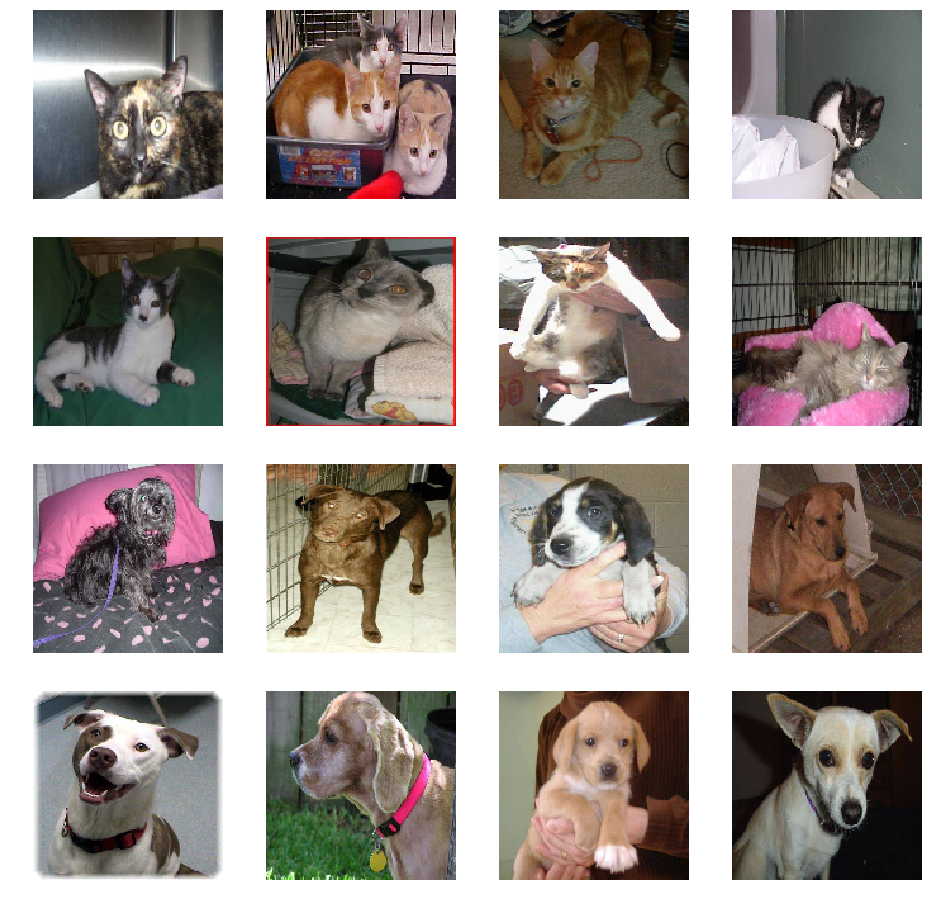

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img =load_img(img_path, target_size=(150, 150))
  plt.imshow(img)

plt.show()

## Data augmentation

### Exploring Data Augmentation

Let's get familiar with the concept of **data augmentation**, an essential way to fight overfitting for computer vision models.

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, **our model will never see the exact same picture twice**. This helps prevent overfitting and helps the model generalize better.

This can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the [Keras documentation](https://keras.io/preprocessing/image/). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images. First let's set up our example files, as in Exercise 1.


Next, let's apply the `datagen` transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

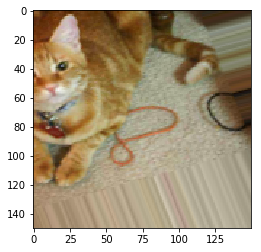

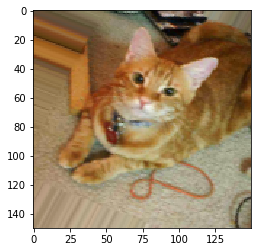

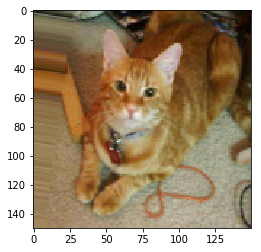

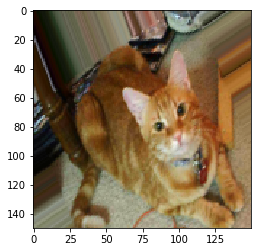

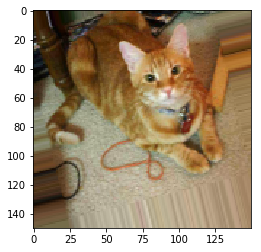

In [7]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

### Add Data Augmentation to the Preprocessing Step

Now let's add our data-augmentation transformations from Exploring Data Augmentation to our data preprocessing configuration:

In [8]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

## Using pre-trained Resnet

In [9]:
from  tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='avg')

x=Dropout(0.2)(resnet.output)
new_output=Dense(1,activation='sigmoid')(x)
new_model=Model(resnet.input,new_output)




## Fine-tune

With data augmentation and dropout in place, let's retrain our convnet model. This time, let's train on all 2,000 images available, for 30 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.) See if you can write the code yourself:


In [10]:
from tensorflow.keras.optimizers import Adam
### user low lr
optimizer=Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [11]:
new_model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [12]:
history = new_model.fit_generator(train_generator,
                                             epochs=100,
                                             validation_data=validation_generator,
                                             workers=8,
                                             verbose=1)

Epoch 1/100
20/20 [==============================] - 30s 1s/step - loss: 0.4812 - acc: 0.8030 - val_loss: 8.1147 - val_acc: 0.4910
Epoch 2/100
20/20 [==============================] - 10s 499ms/step - loss: 0.4456 - acc: 0.8355 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/100
20/20 [==============================] - 10s 486ms/step - loss: 0.3468 - acc: 0.8555 - val_loss: 0.7722 - val_acc: 0.5000
Epoch 4/100
20/20 [==============================] - 10s 491ms/step - loss: 0.2586 - acc: 0.9030 - val_loss: 0.7449 - val_acc: 0.5000
Epoch 5/100
20/20 [==============================] - 10s 480ms/step - loss: 0.2112 - acc: 0.9155 - val_loss: 0.8824 - val_acc: 0.5000
Epoch 6/100
20/20 [==============================] - 10s 483ms/step - loss: 0.1571 - acc: 0.9365 - val_loss: 1.0425 - val_acc: 0.5000
Epoch 7/100
20/20 [==============================] - 10s 482ms/step - loss: 0.1566 - acc: 0.9370 - val_loss: 0.9514 - val_acc: 0.5000
Epoch 8/100
20/20 [==============================] - 10s 492ms/st

Epoch 62/100
20/20 [==============================] - 10s 487ms/step - loss: 0.0677 - acc: 0.9785 - val_loss: 0.6851 - val_acc: 0.8380
Epoch 63/100
20/20 [==============================] - 10s 487ms/step - loss: 0.0519 - acc: 0.9800 - val_loss: 0.3705 - val_acc: 0.8920
Epoch 64/100
20/20 [==============================] - 10s 493ms/step - loss: 0.0392 - acc: 0.9850 - val_loss: 0.4707 - val_acc: 0.8760
Epoch 65/100
20/20 [==============================] - 10s 488ms/step - loss: 0.0675 - acc: 0.9730 - val_loss: 0.7784 - val_acc: 0.7990
Epoch 66/100
20/20 [==============================] - 10s 485ms/step - loss: 0.0623 - acc: 0.9765 - val_loss: 0.2270 - val_acc: 0.9240
Epoch 67/100
20/20 [==============================] - 10s 495ms/step - loss: 0.0357 - acc: 0.9900 - val_loss: 0.2348 - val_acc: 0.9230
Epoch 68/100
20/20 [==============================] - 10s 487ms/step - loss: 0.0334 - acc: 0.9880 - val_loss: 0.3138 - val_acc: 0.8780
Epoch 69/100
20/20 [==============================] - 1

Note that with data augmentation in place, the 2,000 training images are randomly transformed each time a new training epoch runs, which means that the model will never see the same image twice during training.

Let's plot the training and validation loss and accuracy to show it conclusively:

Text(0.5, 1.0, 'Training and validation loss')

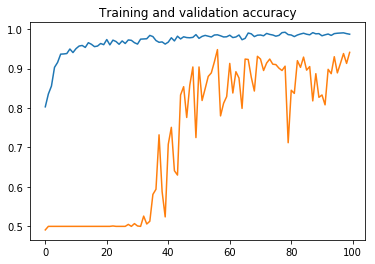

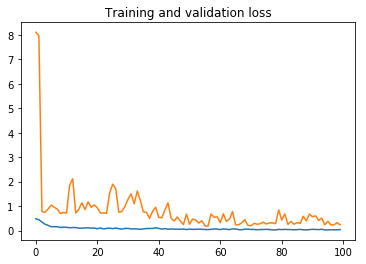

In [13]:

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss,label='val_loss')
plt.title('Training and validation loss')

In [14]:
import numpy as np
np.max(history.history['val_acc'])

0.9480000019073487